# Extrusion force

This notebook process the raw extrusion force data. It takes in the time series of extrusion force, exit temperature and die swell data, and determine stable extrusion regimes based on these data.

## 0 Packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from pathlib import Path
from scipy.interpolate import CubicSpline
import matplotlib.colors as mcolors
from utils import *

Missing colon in file '/home/zhengyang/.config/matplotlib/matplotlibrc', line 37 ("                                        '#d62728', '#9467bd', '#8c564b',")
Missing colon in file '/home/zhengyang/.config/matplotlib/matplotlibrc', line 38 ("                                        '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])")
Bad value in file '/home/zhengyang/.config/matplotlib/matplotlibrc', line 36 ("axes.prop_cycle      : cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c',"): Key axes.prop_cycle: "cycler('color', ['" is not a valid cycler construction: unterminated string literal (detected at line 1) (<unknown>, line 1)
Bad value in file '/home/zhengyang/.config/matplotlib/matplotlibrc', line 43 ('grid.color           : #b0b0b0'): Key grid.color: '' does not look like a color arg


## 1 Time series

Load and plot the time series.

In [2]:
data_folder = Path("/home/zhengyang/Google Drive/Polymaker/003.挤出过程研究/003.挤出测试平台/实验数据/003.散装数据/2025-09-16")
filename = "测试2025.09.16--10-57-s-240.xls"
data = pd.read_csv(data_folder / filename, sep="\t", encoding="gbk")
interval = 0.1

Text(0, 0.5, 'Velocity (mm/s)')

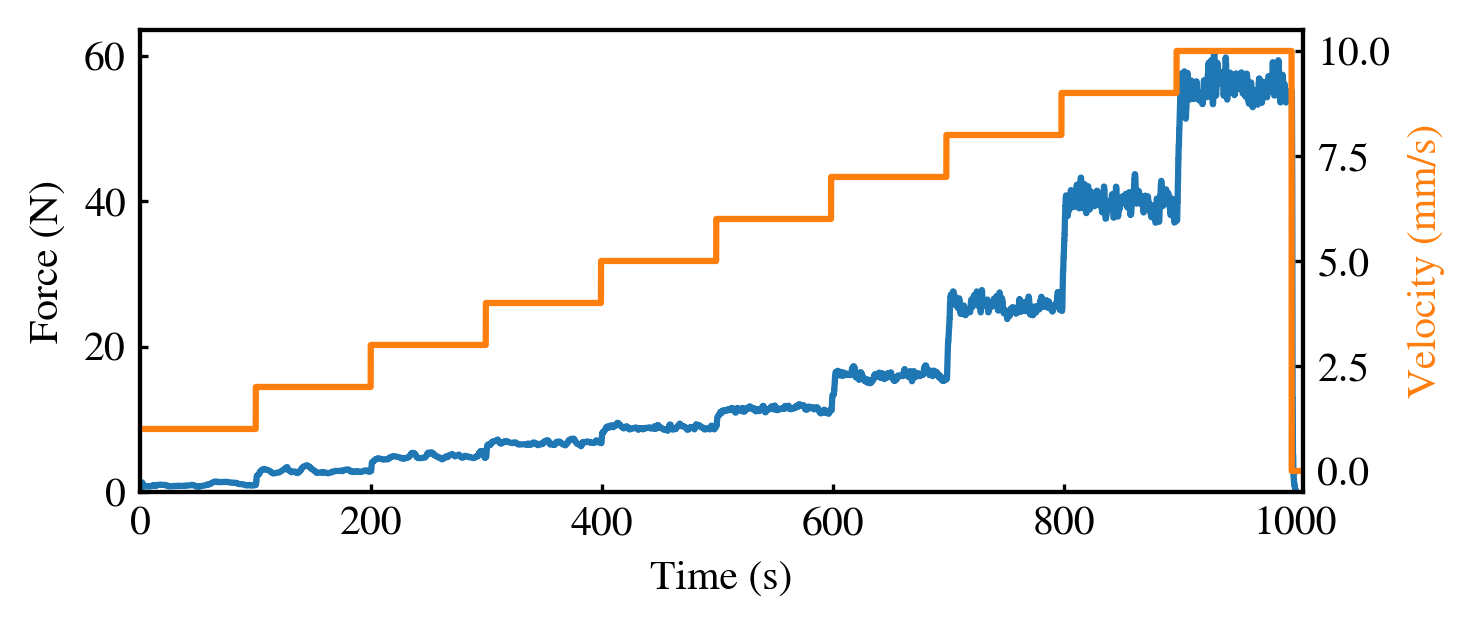

In [4]:
t = data.index * interval
force = data["压力 kg"] * 9.8
velocity = data["当前速度值 mm/s"]
plt.figure(figsize=(5, 2))
plt.plot(t, force)
plt.xlim(0, t.max())
plt.ylim(0, force.max() * 1.05)
plt.xlabel("Time (s)")
plt.ylabel("Force (N)")
ax = plt.gca()
ax1 = ax.twinx()
ax1.plot(t, velocity, color="C1")
ax1.set_ylabel("Velocity (mm/s)", color="C1")

## 2 Separate based on extruder velocity

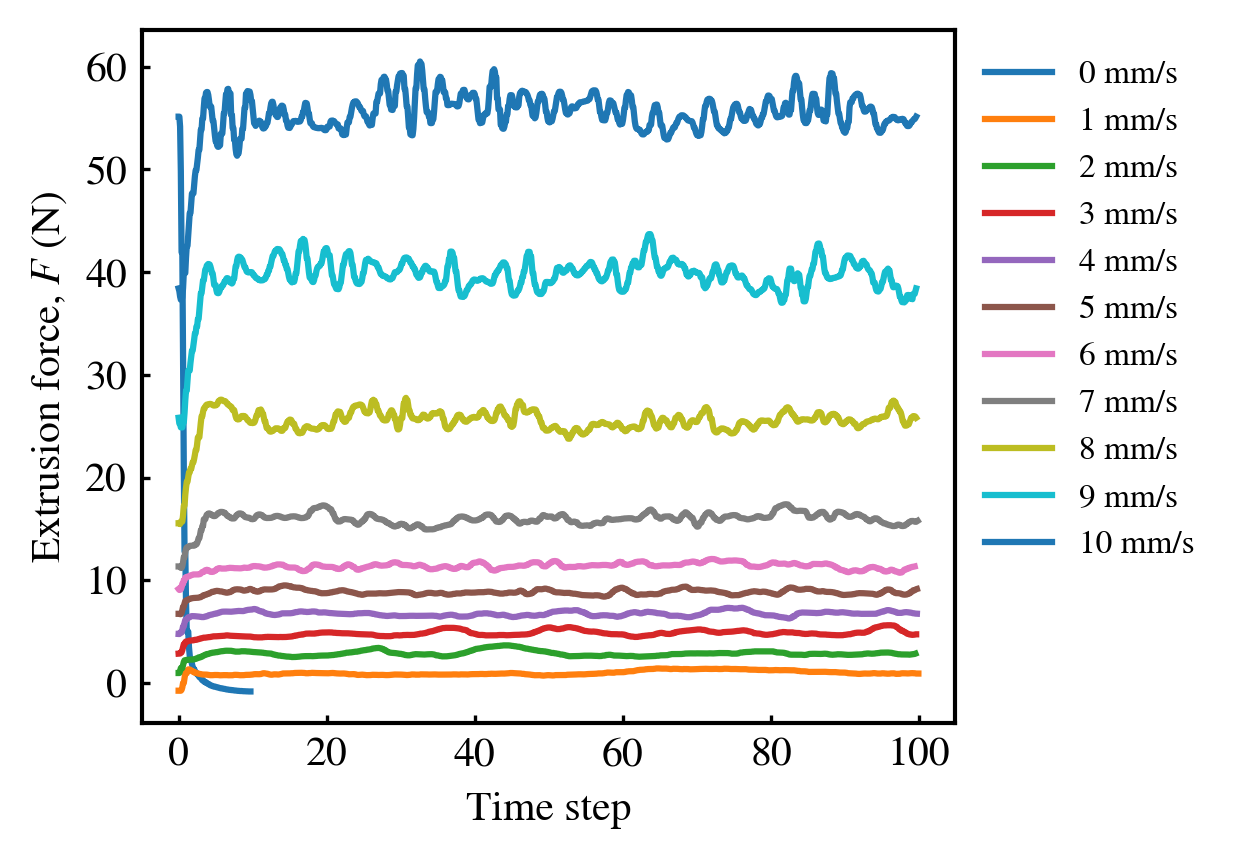

In [3]:
for v, g in data.groupby("当前速度值 mm/s"):
    t = np.arange(len(g)) * interval
    force = g["压力 kg"] * 9.8
    plt.plot(t, force, label=f"{v} mm/s")
plt.xlabel("Time step")
plt.ylabel("Extrusion force, $F$ (N)")
plt.legend(fontsize=8, loc="upper left", bbox_to_anchor=(1, 1))

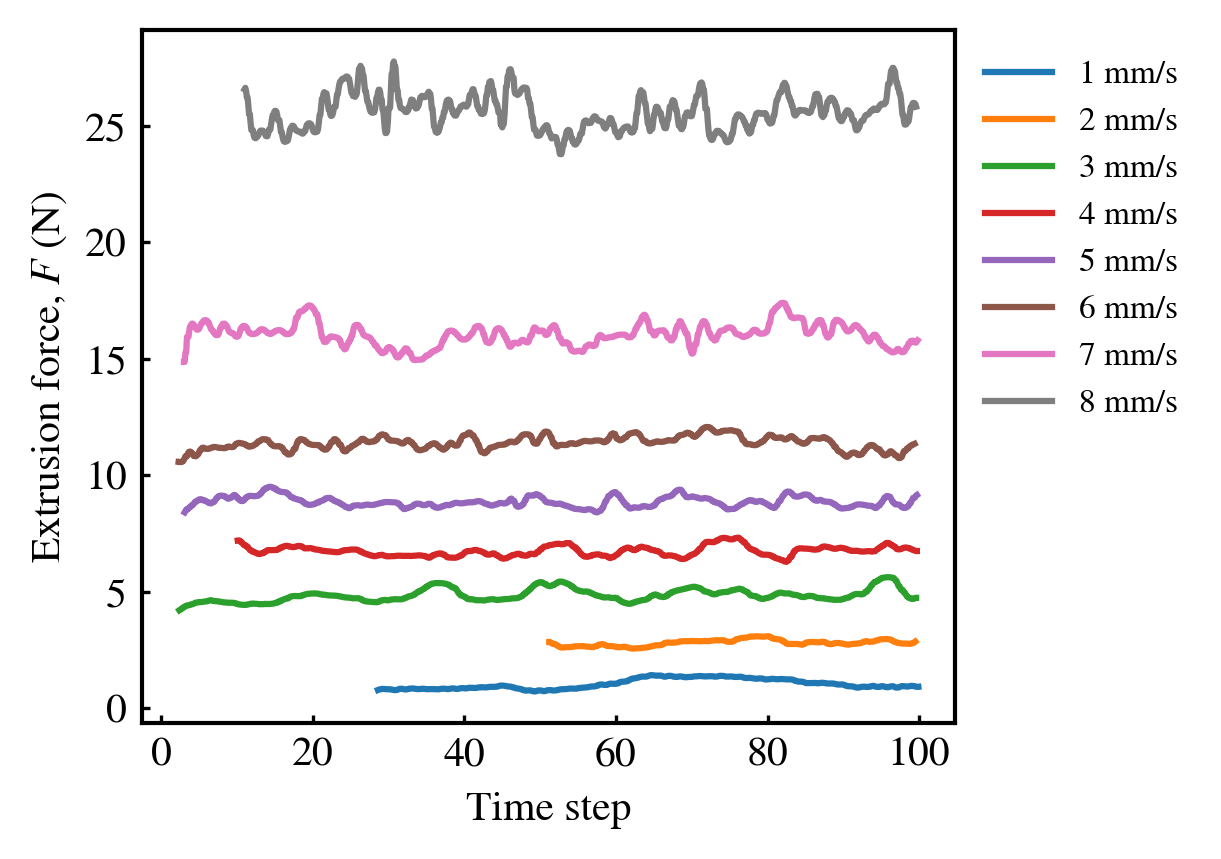

In [10]:
v_list = []
fmean_list = []
fstd_list = []
for v, g in data.groupby("当前速度值 mm/s"):
    if v == 0 or v > 8:
        continue
    ind = find_steady_state_start(g["压力 kg"], window_size=len(g)//10, threshold=0.02)
    if ind is not None:
        t = np.arange(len(g))[ind:] * interval
        force = g["压力 kg"].iloc[ind:] * 9.8
        v_list.append(v)
        fmean_list.append(force.iloc[ind:].mean())
        fstd_list.append(force.iloc[ind:].std())
        plt.plot(t, force, label=f"{v} mm/s")
plt.xlabel("Time step")
plt.ylabel("Extrusion force, $F$ (N)")
plt.legend(fontsize=8, loc="upper left", bbox_to_anchor=(1, 1))

In [11]:
for num, i in g.iterrows():
    if np.isnan(i["压力 kg"]) or np.isnan(i["当前速度值 mm/s"]):
        print(i)

In [12]:
force

7093    26.57074
7094    26.63346
7095    26.50606
7096    26.22578
7097    26.22578
          ...   
7975    25.98666
7976    25.98666
7977    25.97294
7978    25.93766
7979    25.82692
Name: 压力 kg, Length: 887, dtype: float64

In [13]:
ind

np.int64(110)

In [14]:
force.iloc[ind:]

7203    25.95432
7204    25.70246
7205    25.70246
7206    25.50352
7207    25.43198
          ...   
7975    25.98666
7976    25.98666
7977    25.97294
7978    25.93766
7979    25.82692
Name: 压力 kg, Length: 777, dtype: float64

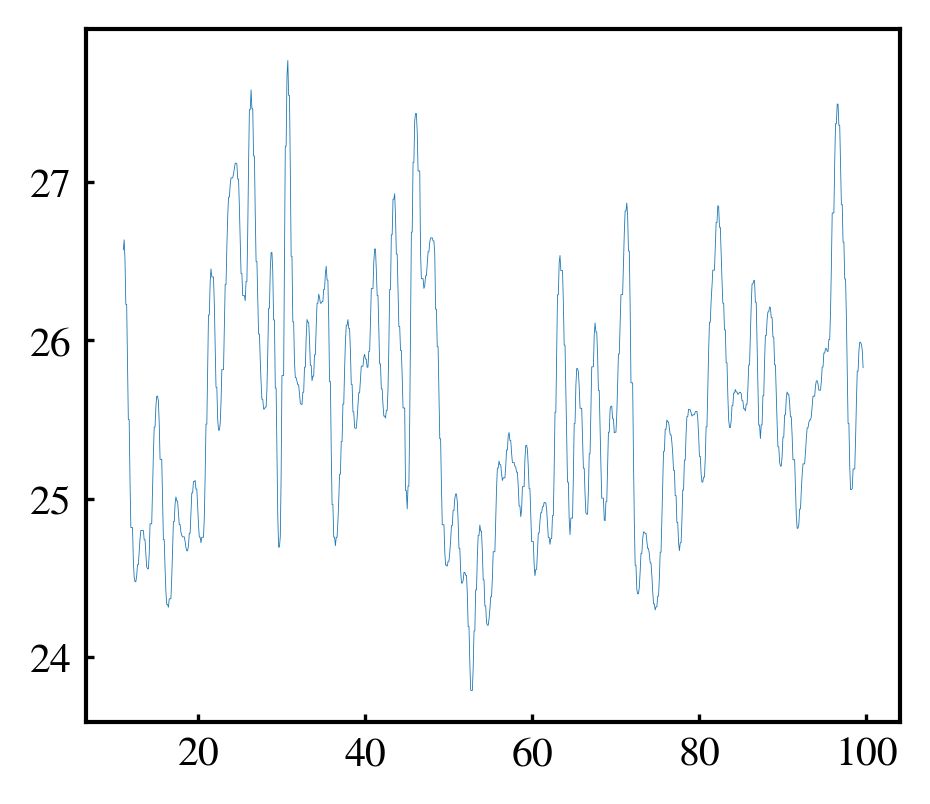

In [15]:
plt.plot(t, force, lw=0.2)

## 3 Critical extruder velocity

In [16]:
df = pd.DataFrame({"速度": v_list, "挤出力": fmean_list, "挤出力标准差": fstd_list})

In [23]:
df = df.dropna()

In [24]:
df

,速度,挤出力,挤出力标准差
0,1,1.180096,0.177190
2,3,4.873427,0.271269
3,4,6.744087,0.214516
4,5,8.869532,0.217650
5,6,11.413682,0.268338
6,7,16.044353,0.482774
7,8,25.639489,0.747849


In [20]:
transition_velocity

TypeError: unsupported format string passed to NoneType.__format__

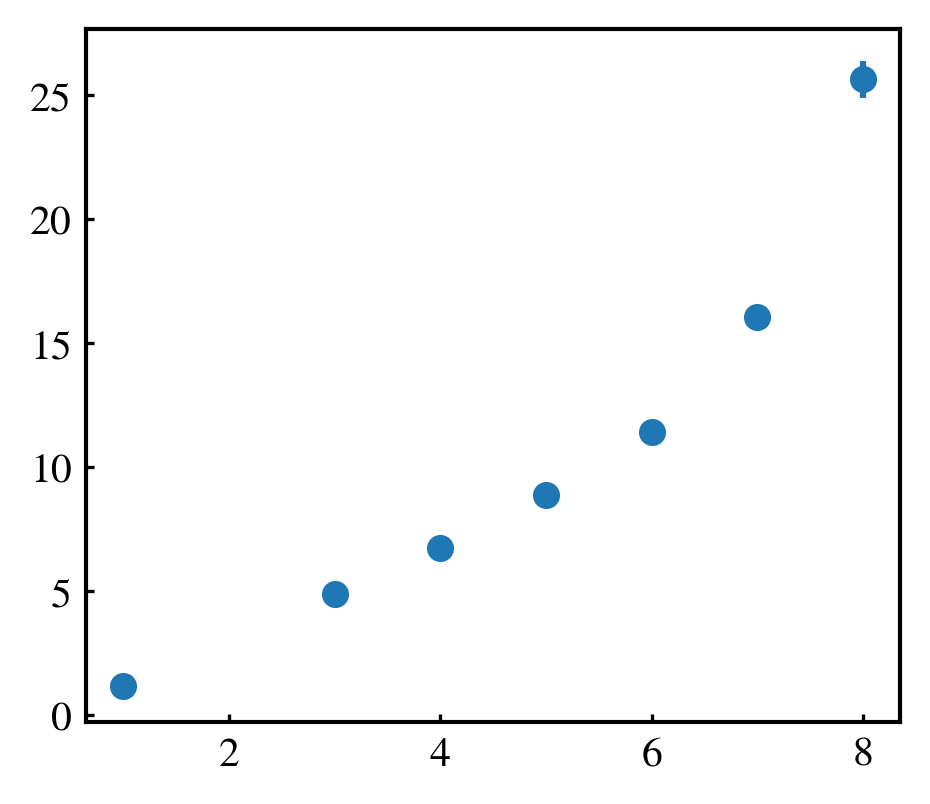

In [25]:
# find transition extruder velocity
transition_velocity = find_force_transition_velocity(df, thres=0.02) # this threshold value may be correlated with the experimental noise level

plt.errorbar(v_list, fmean_list, yerr=fstd_list, marker="o", ls="")
plt.axvline(transition_velocity, color="C3", ls="--", label=f"Transition velocity: {transition_velocity:.2f} mm/s")
plt.xlabel("Extruder velocity, $v$ (mm/s)")
plt.ylabel("Mean extrusion force, $F$ (N)")
plt.xlim(0, max(v_list) * 1.05)
plt.ylim(0, max(fmean_list) * 1.05)

## 4 Process multiple datasets

In [26]:
data_folder = Path("/home/zhengyang/Google Drive/Polymaker/003.挤出过程研究/003.挤出测试平台/实验数据/003.散装数据/2025-09-16")
filenames = {
    200 : "测试2025.09.16--11-15-s-200.xls",
    210 : "测试2025.09.16--10-04-s-210.xls",
    220 : "测试2025.09.16--10-20-s-220.xls",
    230 : "测试2025.09.16--10-38-s-230.xls",
    240 : "测试2025.09.16--10-57-s-240.xls"
}
interval = 0.1

In [27]:
dfs = []
for T in filenames:
    filename = filenames[T]
    data = pd.read_csv(data_folder / filename, sep="\t", encoding="gbk")
    v_list = []
    fmean_list = []
    fstd_list = []
    for v, g in data.groupby("当前速度值 mm/s"):
        if v == 0:
            continue
        ind = find_steady_state_start(g["压力 kg"], window_size=len(g)//10, threshold=0.02)
        if ind is not None:
            t = np.arange(len(g))[ind:] * interval
            force = g["压力 kg"].iloc[ind:] * 9.8
            v_list.append(v)
            fmean_list.append(force.iloc[ind:].mean())
            fstd_list.append(force.iloc[ind:].std())
    df = pd.DataFrame({"速度": v_list, "挤出力": fmean_list, "挤出力标准差": fstd_list, "温度": T})
    dfs.append(df)

200 5.575757575757576
210 6.181818181818182
220 6.434343434343434
230 6.818181818181818
240 7.232323232323232


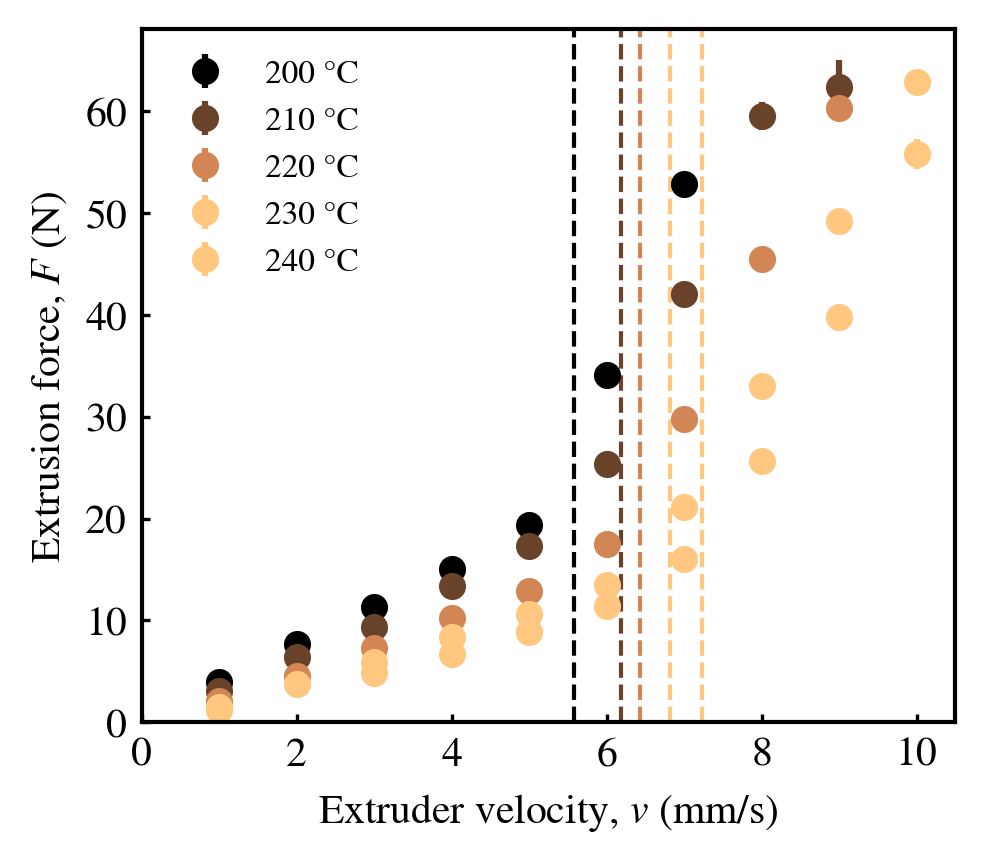

In [28]:
cmap = plt.get_cmap("copper", 4)
T_list = []
vc_list = []
for i, df in enumerate(dfs):
    color = cmap(i)
    velocity = df["速度"]
    force = df["挤出力"]
    force_std = df["挤出力标准差"]
    T = df['温度'].iloc[0]
    transition_velocity = find_force_transition_velocity(df, thres=0.02)
    plt.errorbar(velocity, force, yerr=force_std, color=color, marker="o", ls="", label=f"{T} °C")
    plt.axvline(transition_velocity, color=color, ls="--", lw=1)
    T_list.append(T)
    vc_list.append(transition_velocity)
    print(T, transition_velocity)
plt.xlabel("Extruder velocity, $v$ (mm/s)")
plt.ylabel("Extrusion force, $F$ (N)")
plt.xlim(0, 10.5)
plt.ylim(0, 68)
plt.legend(fontsize=8, loc="upper left")


In [6]:
g["压力 kg"].iloc[ind:]

8977    3.8815
8978    3.8437
8979    3.8437
Name: 压力 kg, dtype: float64

In [7]:
T_list

[np.int64(200), np.int64(210), np.int64(220), np.int64(230), np.int64(240)]

### 4.2 Predicted and actual critical filament velocity

In [31]:
# sample 7
# measured = np.array([180, 185, 185, 195, 235]) * 0.035
# error = np.array([10, 5, 5, 5, 5]) * 0.035
measured = np.array([np.nan, 195, 195, 205, np.nan]) * 0.035
error = np.array([np.nan, 5, 5, 5, np.nan]) * 0.035

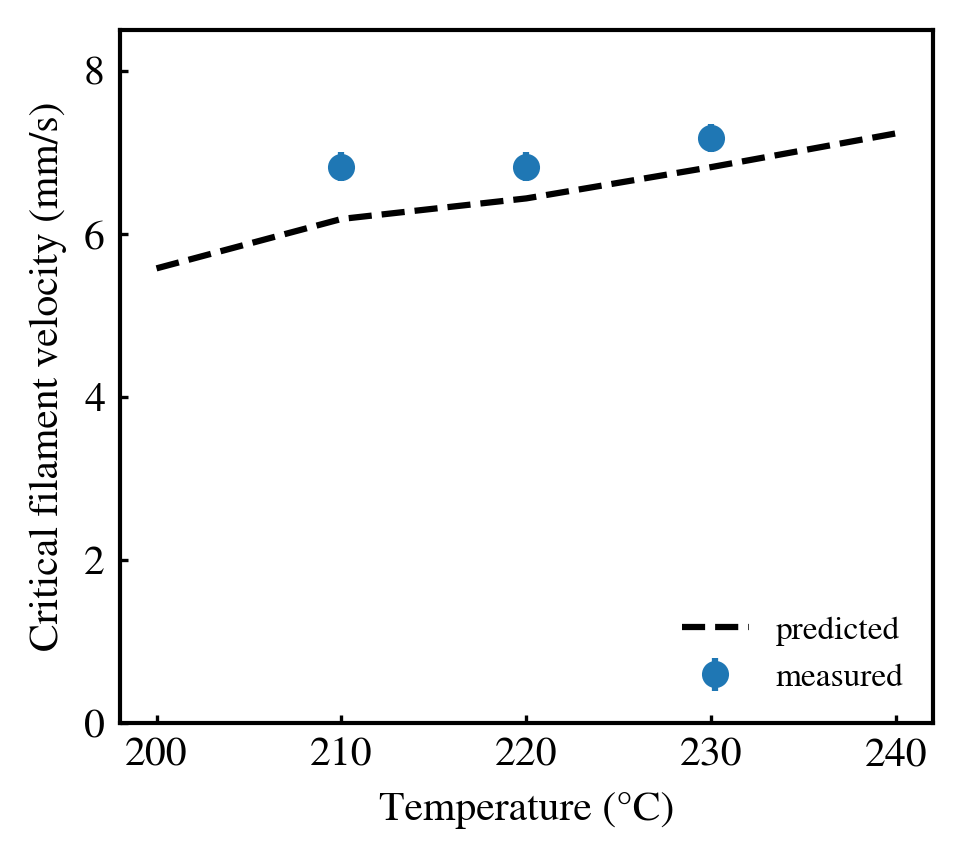

In [32]:
plt.plot(T_list, vc_list, ls="--", color="k", label="predicted")
plt.errorbar(T_list, measured, yerr=error, marker="o", ls="", label="measured")
plt.xlabel("Temperature (°C)")
plt.ylabel("Critical filament velocity (mm/s)")
plt.ylim(0, 8.5)
plt.legend(fontsize=8, loc="lower right")